# Projeto-ICD: Análise de dados sobre sentimentos e reações do público nas premiações do Oscar

**Integrantes:** Lucas Marinho, Lucas Nery, Giulle e Gustavo

## 1. Introdução

**Motivação:**  
As premiações do Oscar geram enorme repercussão nas redes sociais.  
Queremos entender como o público reage — em termos de sentimento — aos anúncios de vencedores e momentos marcantes da cerimônia.

**Objetivos:**  
1. Quantificar a distribuição de sentimentos (positivo, neutro e negativo).  
2. Verificar quais comentários geram mais engajamento (upvotes).  
3. Identificar padrões na profundidade das conversas (campo `depth`).  

## 2. Dados Usados

Neste projeto, utilizamos principalmente informações extraídas do Reddit, a partir do post anual do subreddit **r/Oscars**.  
O foco, nesta etapa, está na análise dos **comentários** coletados, conforme detalhado abaixo.

### 2.1 Origem e Coleta dos Dados

- **Fonte**: Reddit, post anual do subreddit r/Oscars  
- **API utilizada**: PRAW (Python Reddit API Wrapper)  
- **Procedimento**:  
  1. Acessamos o post principal do Oscar no r/Oscars via PRAW, recuperando título, texto, autor e metadados do post.  
  2. Iteramos sobre todos os comentários (incluindo aninhamentos), armazenando texto, autor, votos e profundidade.  
  3. Para cada comentário, aplicamos VADER para classificação de sentimento (positivo, neutro ou negativo).

### 2.2 Formato e Tamanho dos Arquivos

| Arquivo                                 | Linhas | Colunas |
|-----------------------------------------|-------:|--------:|
| post_coletado.csv                       |      1 |        9 |
| comentarios_coletados.csv               | 12 811 |        4 |
| post_coletado_br.csv                    |      1 |        9 |
| comentários_coletados_br_final.csv      |  2 498 |        6 |

- **post_coletado.csv**: post onde os comentários foram coletados (todos os idiomas).
- **comentarios_coletados.csv**: amostra geral de comentários (todos os idiomas).
- **post_coletado_br.csv**: post onde os comentários foram coletados (Brasil).
- **comentários_coletados_br_final.csv**: filtragem apenas para comentários em português (Brasil), com colunas extras de autor e data.


### 2.3 Descrição das Colunas (comentários)

| Coluna      | Tipo    | Descrição                                                         |
|-------------|---------|-------------------------------------------------------------------|
| comentário  | object  | Texto completo do comentário                                      |
| sentimento  | object  | Rótulo de sentimento (positivo / neutro / negativo), via VADER    |
| upvotes     | int64   | Quantidade de votos positivos recebidos                           |
| depth       | int64   | Profundidade na thread (0 = comentário raiz, 1 = resposta, etc.)  |
| autor       | object  | Nome de usuário do autor (presente somente em _br_final_)         |
| data        | object  | Data e hora da publicação (presente somente em _br_final_)        |

### 2.4 Verificação de tipos

In [46]:
print("### comentarios_coletados.csv ###")
df_all.info()

print("\n### comentários_coletados_br_final.csv ###")
df_br.info()

### comentarios_coletados.csv ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comentário  12811 non-null  object
 1   sentimento  12811 non-null  object
 2   upvotes     12811 non-null  int64 
 3   depth       12811 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 400.5+ KB

### comentários_coletados_br_final.csv ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comentário  2497 non-null   object
 1   sentimento  2498 non-null   object
 2   upvotes     2498 non-null   int64 
 3   depth       2498 non-null   int64 
 4   autor       2430 non-null   object
 5   data        2498 non-null   object
dtypes: int64(2), object(4)
memory usage: 117.2+ KB


### 2.5 Importação e Carregamento

In [82]:
import pandas as pd
import matplotlib.pyplot as plt # Importar bibliotecas de plot

# Carregando os datasets de comentários
df_all = pd.read_csv('data/comentarios_coletados.csv')
df_br  = pd.read_csv('data/comentários_coletados_br_final.csv')

### 2.6 Primeira Visualização

In [44]:
print("— Primeiras 5 linhas de comentarios_coletados.csv —")
display(df_all.head())

print("\n— Primeiras 5 linhas de comentários_coletados_br_final.csv —")
display(df_br.head())

— Primeiras 5 linhas de comentarios_coletados.csv —


,comentário,sentimento,upvotes,depth
0,"Congrats on the upcoming sex, Kieran",positivo,93,0
1,"Ohh, he's going in!",neutro,4,1
2,Fhritp,neutro,2,1
3,First woman of Dominican origin to win an Osca...,positivo,95,0
4,It’s coming 😂,neutro,3,1



— Primeiras 5 linhas de comentários_coletados_br_final.csv —


,comentário,sentimento,upvotes,depth,autor,data
0,https://preview.redd.it/srbaoego7eme1.jpeg?wid...,neutro,61,0,sorryperiferia,2025-03-03 00:20:27
1,And the bags they pull...,neutro,13,1,NorthHealthy4921,2025-03-03 00:21:43
2,So happy for you Brazilians!!!,positivo,57,0,BrightNeonGirl,2025-03-03 00:11:49
3,"Thank you, kind foreigner! AAAAAAH HOW HAPPY ...",positivo,6,1,Emb_IvanAwfulitch,2025-03-03 00:13:39
4,THANK YOU MY FELLOW GRINGO!!!!!,positivo,7,1,emperorzura,2025-03-03 00:14:19


### 2.7 Exploração Inicial

Nesta etapa, vamos rapidamente:
- Verificar distribuição de sentimentos  
- Obter estatísticas de upvotes e profundidade  
- Contagem de duplicatas e valores faltantes em `autor` (BR)

### 2.7.1 Distribuição de sentimentos

,Conjunto,# comentários,% positivos,% neutros,% negativos
0,Geral,12811,42.87,35.40,21.73
1,BR,2498,20.06,68.61,11.33


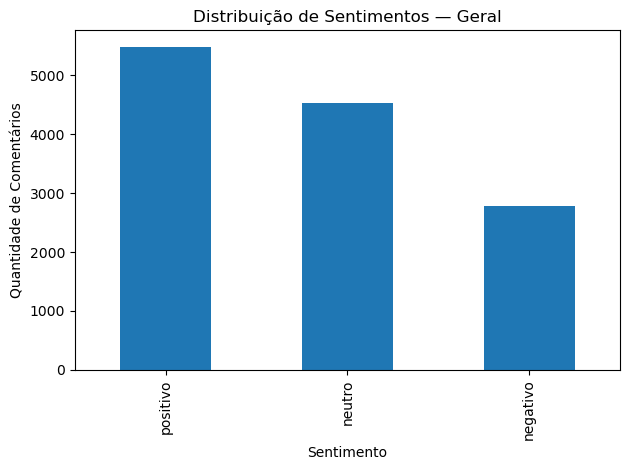

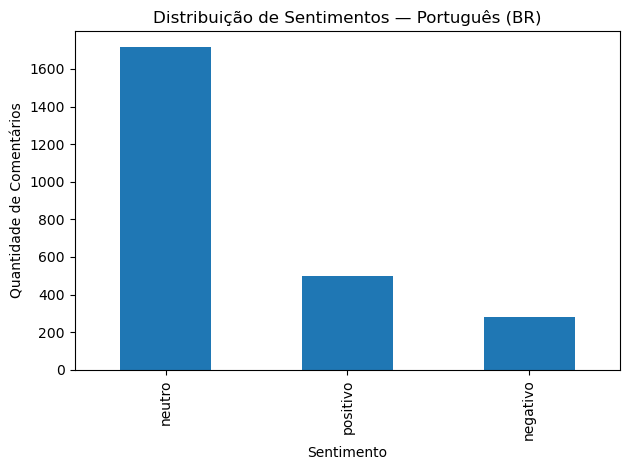

In [84]:
# 1) Função que monta a linha de resumo
def resumo_sentimentos(df, nome):
    total = len(df)
    pct = df['sentimento'].value_counts(normalize=True) * 100
    return {
        'Conjunto': nome,
        '# comentários': total,
        '% positivos': round(pct.get('positivo', 0), 2),
        '% neutros':   round(pct.get('neutro',   0), 2),
        '% negativos': round(pct.get('negativo', 0), 2),
    }

# 2) Montar DataFrame-resumo
summary = pd.DataFrame([
    resumo_sentimentos(df_all, 'Geral'),
    resumo_sentimentos(df_br,  'BR')
])

# 3) Exibir a tabela
display(summary)

# Gráficos de distribuição de sentimentos
plt.figure()
sent_all.plot(kind='bar')
plt.title('Distribuição de Sentimentos — Geral')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

plt.figure()
sent_br.plot(kind='bar')
plt.title('Distribuição de Sentimentos — Português (BR)')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

### 2.7.2 Estatísticas de upvotes e depth

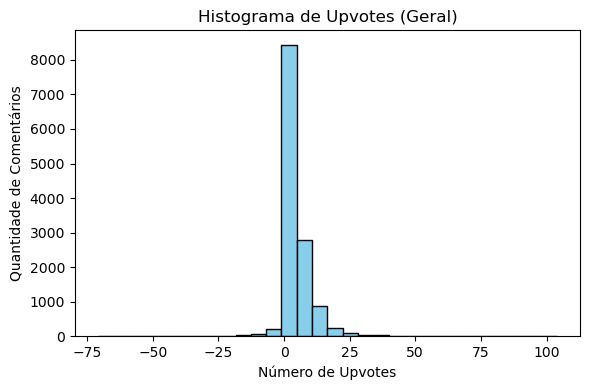

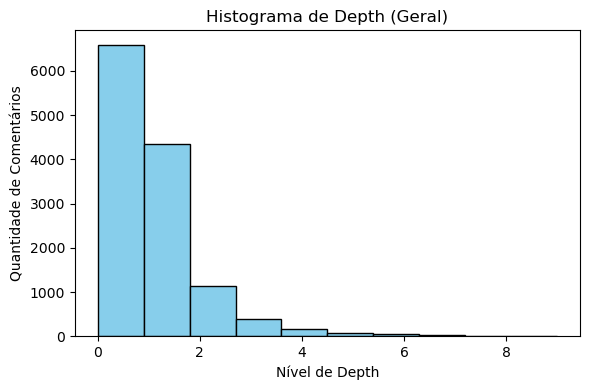

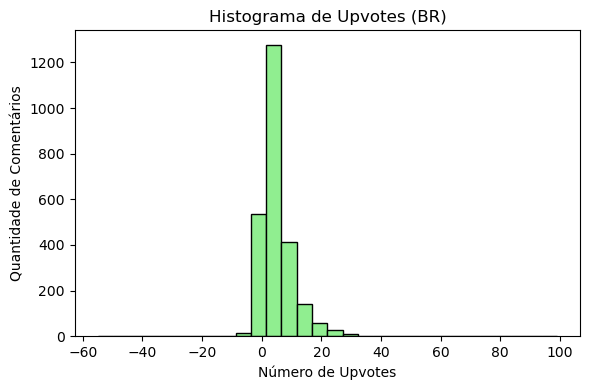

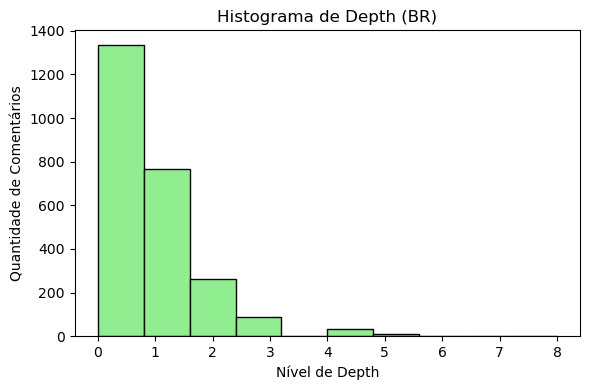

In [83]:
import pandas as pd

# Histograma de UPVOTES - Todos
plt.figure(figsize=(6,4))
plt.hist(df_all['upvotes'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Upvotes (Geral)')
plt.xlabel('Número de Upvotes')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

# Histograma de DEPTH - Todos
plt.figure(figsize=(6,4))
plt.hist(df_all['depth'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histograma de Depth (Geral)')
plt.xlabel('Nível de Depth')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

# Histograma de UPVOTES - BR
plt.figure(figsize=(6,4))
plt.hist(df_br['upvotes'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma de Upvotes (BR)')
plt.xlabel('Número de Upvotes')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

# Histograma de DEPTH - BR
plt.figure(figsize=(6,4))
plt.hist(df_br['depth'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Histograma de Depth (BR)')
plt.xlabel('Nível de Depth')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

### 2.7.3 Verificação de valores duplicados/faltantes

In [90]:
# Verificação de duplicatas antes do pré-processamento
dup_all = df_all.duplicated(subset='comentário').sum()
dup_br  = df_br.duplicated(subset='comentário').sum()

print(f"Duplicatas em Geral: {dup_all} de {len(df_all)} ({dup_all/len(df_all):.2%})")
print(f"Duplicatas em BR:    {dup_br} de {len(df_br)} ({dup_br/len(df_br):.2%})\n")

# Verificação de valores faltantes
nulos = df_br['autor'].isna().sum()
print(f"Comentários sem autor: (BR): {nulos} de {len(df_br)} ({nulos/len(df_br):.1%})\n")

Duplicatas em Geral: 434 de 12811 (3.39%)
Duplicatas em BR:    52 de 2498 (2.08%)

Comentários sem autor: (BR): 68 de 2498 (2.7%)

